# 1. Load Dataset from the Internet (link below) into keras/tensorflow

https://dagshub.com/kingabzpro/Speech_Commands_Dataset

You can see the data on the left under the "data"-Folder 

If data is loaded, it won't load twice (line 4)

!Wichtig: Der Datensatz enthält nur Monoaufnahmen 

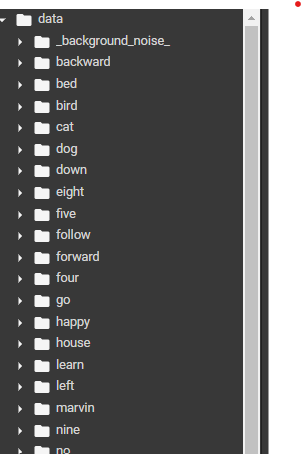

In [1]:
import os
import pathlib
import shutil
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import wave
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
#Dateipfad aller Daten im Verzeichnis "data"
DATASET_PATH = 'data'
#Dateipfad der für das ML-Model Training ausgewählten Daten
AUDIO_SUBFOLDER = 'audio'
#Füge Audio-Ordner in dem Data-Ordner ein
DATASET_AUDIO_PATH = os.path.join(DATASET_PATH, AUDIO_SUBFOLDER)

data_dir = pathlib.Path(DATASET_PATH)
#Lade Daten herunter, wenn sie nicht bereits heruntergeladen sind 
if not data_dir.exists():
  tf.keras.utils.get_file(
      'speech_commands_v0.02.tar.gz',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data')

2428936192/2428923189 [==============================] - 24s 0us/step


### 1.1 Extrahiere die zu klassifizierenden Wörter aus dem Datensatz mit denen das Modell trainiert werden soll

Move die Folder mit den relevanten Datensatzen in den "audio"-folder

DATASET_AUDIO_PATH gibt den Datenpfad zu dem directory an 
Filtere die Audiofiles zu den Wörtern "Dog, Cat, Bird, House und Bed" heraus, da das Model erstmal nur auf diese Wörter trainiert werden soll

Die Audioclips des Datensatzes werden in 36 Ordnern gespeichert, die jedem Sprachbefehl "bed", "bird, "cat", "dog" etc entsprechen

(Screenshot zeigt exemplarisch alle möglichen commands des dataset)

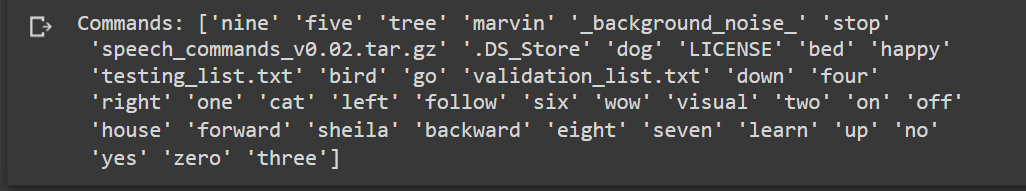

In [3]:
#Erstelle Audio-Ordner, wenn er noch nicht vorhanden ist
if os.path.exists(DATASET_AUDIO_PATH) is False:
    os.makedirs(DATASET_AUDIO_PATH)
#Iteriere über heruntergeladene Ordner, "folder" enthält den Ordnernamen 
for folder in os.listdir(data_dir):
  if os.path.isdir(os.path.join(DATASET_PATH, folder)):
    #Filter Bedingung: nur die Ordner "dog", "cat", "bird" etc werden fürs Training verwendet
    if folder == "dog" or folder == "cat" or folder == "bird" or folder == "house" or folder == "bed":

      if folder in AUDIO_SUBFOLDER:
        continue
      else:
        #wenn folder noch nicht in Audio-Ordner ist, füge ihn ein
        shutil.move(
            os.path.join(DATASET_PATH, folder),
            os.path.join(DATASET_AUDIO_PATH, folder),
        )
        print(folder) #wird irgendwie nix geprinted

#Directory der herausgesuchten Audiodaten
data_audio_dir = pathlib.Path(DATASET_AUDIO_PATH)

house
cat
bird
bed
dog


In [4]:
#Gebe die Wörter aus die gelern werden können
commands = np.array(tf.io.gfile.listdir(str(data_audio_dir))) 
print("All Commands: ", commands)

All Commands:  ['house' 'cat' 'bird' 'bed' 'dog']


In [ ]:
#Gebe alle Dateien aus dem Audio-Ordner aus
print(str(data_audio_dir/commands[0]))
tf.io.gfile.listdir(str(data_audio_dir/commands[0]))

Extrahiere Audioclips in eine Liste namens "filenames" und mische sie  


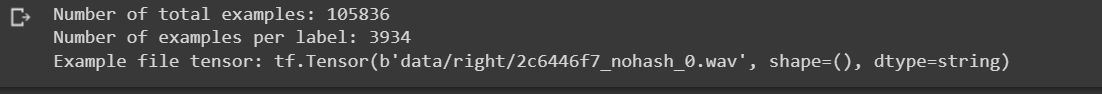

In [9]:
filenames = tf.io.gfile.glob(str(data_audio_dir) + '/*/*')
# Umwandlung von Strings in EagerTensor
filenames = tf.random.shuffle(filenames) 
# Anzahl der zu lernenden Labels
num_samples = len(filenames)

print('Number of total examples:', num_samples)
print('Number of examples per label:',len(tf.io.gfile.listdir(str(data_audio_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 10350
Number of examples per label: 2113
Example file tensor: tf.Tensor(b'data/audio/bird/b84f83d2_nohash_0.wav', shape=(), dtype=string)


In [11]:
#Wähle Anzahl der Trainings, Validierungs und Test Files aus nach dem 80-10-10 Prinzip
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
# test_files ist eine List von EagerTensor zu Audiodateien z.B. b'data/audio/cat/bd76a7fd_nohash_0.wav' | Type test_files[0]:  <class 'tensorflow.python.framework.ops.EagerTensor'>
test_files = filenames[-800:] 
print("test_files: ", type(test_files[0]))
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))
print(filenames[0])

test_files:  <class 'tensorflow.python.framework.ops.EagerTensor'>
Training set size 6400
Validation set size 800
Test set size 800
tf.Tensor(b'data/audio/bird/b84f83d2_nohash_0.wav', shape=(), dtype=string)


# 2. Preprocessing Functions
Datensatz wird vorverarbeitet und decodierte Tensoren für die Wellenformen und die entsprechenden Labels erstellt. 

Zu Beachten ist, dass
- Jede WAV-Datei enthält Zeitreihendaten mit einer festgelegten Anzahl von Samples pro Sekunde.

- Jedes Sample repräsentiert die Amplitude des Audiosignals zu diesem bestimmten Zeitpunkt.

- In einem 16-Bit- System, wie den WAV-Dateien im Mini-Datensatz für Sprachbefehle, reichen die Amplitudenwerte von -32.768 bis 32.767.

- Die Abtastrate (sample rate) für diesen Datensatz beträgt 16 kHz.

Zurückgegebener Shape der tensoren von tf.audio.decode_wav
ist [samples, channels], 
(Channels steht für  Mono oder Stereo 

!Wichtig: Der Datensatz enthält nur Monoaufnahmen 


In [12]:
#Lese Audiodateien und Labels

test_file = tf.io.read_file(DATASET_AUDIO_PATH+'/bed/4beff0c5_nohash_1.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
print("test_audio: ", type(test_audio))
test_audio.shape

test_audio:  <class 'tensorflow.python.framework.ops.EagerTensor'>


TensorShape([10923, 1])

 *decode_audio()*:  
 - Funktion, die die rohen WAV-Audiodateien in Audiotensoren vorverarbeitet

In [13]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

*get_label():* 
- Funktion die Labeles unter Verwendung der übergeordneten Verzeichnisse für jede Datei erstellt

In [14]:
def get_label(file_path):
  print("file_path: ", file_path)
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

*get_waveform_and_label()*: 
- Funktion, die alles zusammenfasst: Eingabe ist der WAV-Audiodateiname; Ausgabe ist ein Tupel, das die Audio- & Label Tensoren enthält, die fürs supervised Learning bereit sind

In [15]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  print("label",label)
  audio_binary = tf.io.read_file(file_path)
  print("audio_binary", audio_binary)
  waveform = decode_audio(audio_binary)
  print("waveform", waveform)
  return waveform, label

Erstellen des Trainingssets, um die Audio-Label-Paare zu extrahieren:

- Erstellen einer tf.data.Datasetmit Dataset mit **from_tensor_slices** und **Dataset.map,** wobei die Funktion  **get_waveform_and_label** verwendet wird. 

( Validierungs- & Testsätze werden später mit einem ähnlichen Verfahren erstellt)

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

file_path:  Tensor("args_0:0", shape=(), dtype=string)
label Tensor("strided_slice:0", shape=(), dtype=string)
audio_binary Tensor("ReadFile:0", shape=(), dtype=string)
waveform Tensor("Squeeze:0", shape=(None,), dtype=float32)


# 3. Visualisierungen von Audio-Waveformen Diagrammen & Spektogrammen
Visualisiere Audio-Wellenformen Diagramme mit Wave-Form und Label

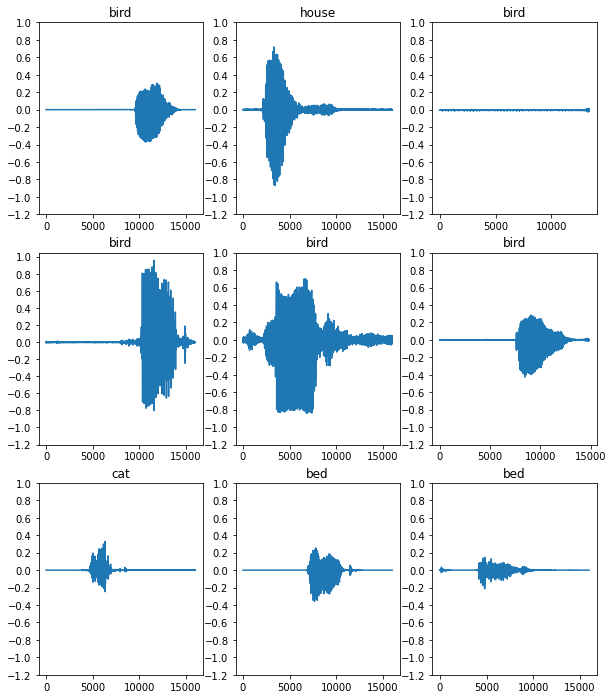

In [17]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

Konvertiere Wellenform in ein Spektogramm

In [18]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

- Gebe ausgewählte Audio Datei aus 
- Zeige beispielhaft Wave-Form und das dazugehörige Spektogramm an

In [19]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: bird
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [20]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

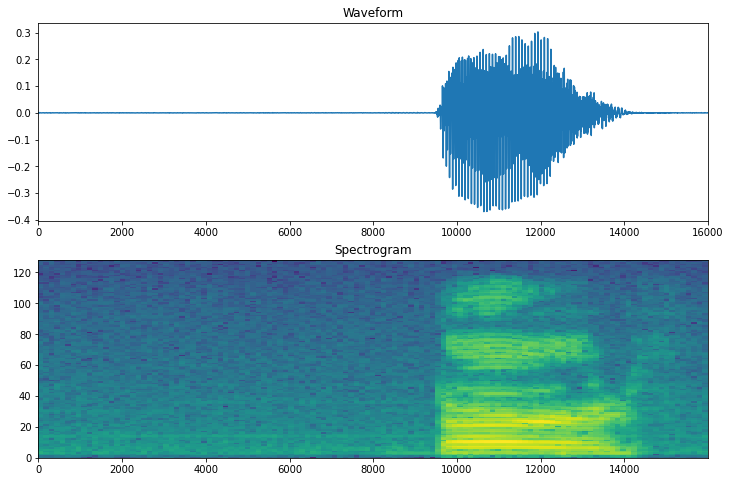

In [21]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

function: get_spectrogram_and_label_id
- Definieren Sie nun eine Funktion, die den Wellenformdatensatz in Spektrogramme und ihre entsprechenden Beschriftungen als Integer-IDs umwandelt:

In [22]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

Ordnen get_spectrogram_and_label_idSie die Elemente des Datensatzes mit zu Dataset.map:

In [23]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Untersuchen Sie die Spektrogramme auf verschiedene Beispiele des Datensatzes:

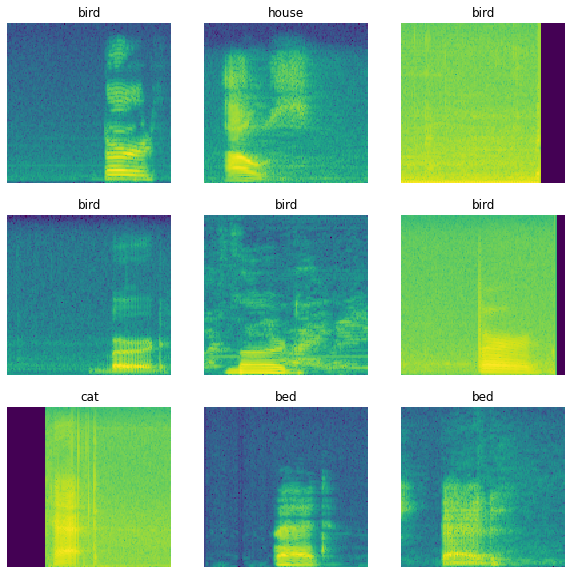

In [24]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

# 4. Erstelle & Trainiere das Modell

preprocessing funktion, welche die obigen Hilfsfunktionen vereint

In [37]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  print("output_ds1: ",output_ds)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  print("output_ds2: ",output_ds)
  return output_ds

IndentationError: ignored

In [27]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files) # List von EagerTensor wird Preprocessed

file_path:  Tensor("args_0:0", shape=(), dtype=string)
label Tensor("strided_slice:0", shape=(), dtype=string)
audio_binary Tensor("ReadFile:0", shape=(), dtype=string)
waveform Tensor("Squeeze:0", shape=(None,), dtype=float32)
file_path:  Tensor("args_0:0", shape=(), dtype=string)
label Tensor("strided_slice:0", shape=(), dtype=string)
audio_binary Tensor("ReadFile:0", shape=(), dtype=string)
waveform Tensor("Squeeze:0", shape=(None,), dtype=float32)


Batchen Sie die Trainings- und Validierungssätze für das Modelltraining:

In [28]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Fügen Sie Dataset.cacheund Dataset.prefetchOperationen hinzu, um die Leselatenz beim Trainieren des Modells zu reduzieren:

In [29]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [30]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
  print(input_shape)

(124, 129, 1)


Für das Modell wird ein  einfaches Convolutional Neural Network (CNN) verwendet, da Sie die Audiodateien in Spektrogrammbilder umgewandelt haben.

Ihr **tf.keras.Sequential** Modell verwendet die folgenden Keras-Vorverarbeitungsebenen:

**tf.keras.layers.Resizing**: 
- Zum Downsampling der Eingabe, damit das Modell schneller trainieren kann.
tf.keras.layers.Normalization: 
- Zum Normalisieren jedes Pixels im Bild basierend auf seinem Mittelwert und seiner Standardabweichung.

Für die **Normalization** Schicht adaptmüsste ihre Methode zuerst für die Trainingsdaten aufgerufen werden, um aggregierte Statistiken (d. h. den Mittelwert und die Standardabweichung) zu berechnen.

In [32]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print("num_labels",num_labels)
# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),# evtl. sigmoid nehmen
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])
model.summary()

Input shape: (124, 129, 1)
num_labels 5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropou

Konfigurieren Sie das Keras-Modell mit dem Adam-Optimierer und dem Kreuzentropieverlust:

In [33]:
# Compile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [34]:
model.save('/hello_world/model1.h5')
from tensorflow import keras
my_saved_model = keras.models.load_model("/hello_world/model1.h5")

In [38]:
# Train model
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
100/100 [==============================] - 22s 216ms/step - loss: 0.1248 - accuracy: 0.2023 - val_loss: 0.3469 - val_accuracy: 0.2313
Epoch 2/20
100/100 [==============================] - 22s 216ms/step - loss: 0.1268 - accuracy: 0.2030 - val_loss: 0.3210 - val_accuracy: 0.2237
Epoch 3/20
100/100 [==============================] - 29s 293ms/step - loss: 0.1064 - accuracy: 0.2030 - val_loss: 0.3286 - val_accuracy: 0.2262
Epoch 4/20
100/100 [==============================] - 22s 216ms/step - loss: 0.0975 - accuracy: 0.2041 - val_loss: 0.3268 - val_accuracy: 0.2200
Epoch 4: early stopping


In [39]:
#https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-save-and-load-a-model-with-keras.md
from tensorflow.keras.models import Sequential, save_model
filepath = './saved_model1234'
# Save the model as "saved_model"
save_model(model, filepath)
#or save model in .h5-Format
#save_model(model, filepath, save_format='h5')

INFO:tensorflow:Assets written to: ./saved_model1234/assets


In [40]:
#load model
from tensorflow.keras.models import Sequential, save_model, load_model
import numpy as np
# Load the model
# Load the model
loaded_model = load_model(
    filepath,
    custom_objects=None,
    compile=True
)

sample_file = "/content/data/go/004ae714_nohash_0.wav"
sample_ds = preprocess_dataset([str(sample_file)])

print(sample_ds)

file_path:  Tensor("args_0:0", shape=(), dtype=string)
label Tensor("strided_slice:0", shape=(), dtype=string)
audio_binary Tensor("ReadFile:0", shape=(), dtype=string)
waveform Tensor("Squeeze:0", shape=(None,), dtype=float32)
<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


Visualisiere die  Trainings- und Validierungsverlustkurven, um zu überprüfen, wie sich Ihr Modell während des Trainings verbessert hat:

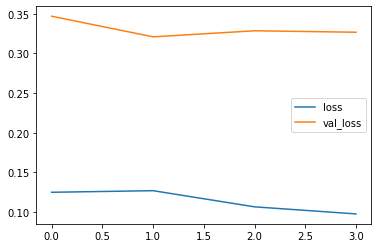

In [41]:
# Unterschied zw loss & val_loss
#https://datascience.stackexchange.com/questions/25267/keras-difference-beetween-val-loss-and-loss-during-training

metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# 5. Testen des Modells

Ausführen des Modells auf dem Testset

In [42]:
# Test Datensatz
test_audio = []
test_labels = []
#test_ds = preprocess_dataset(test_files) # List von EagerTensor wird Preprocessed

for audio, label in test_ds:

  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio) #test_audio:  <class 'numpy.ndarray'>
print("test_audio: ", type(test_audio[0]))
test_labels = np.array(test_labels)

test_audio:  <class 'numpy.ndarray'>


In [ ]:
#type sample_ds:  <class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
#filenames[0] "data/audio/bird/e9b61425_nohash_0.wav"
# test_audio, _ = tf.audio.decode_wav(contents=test_file)

In [43]:
# ---------------- Einzel Audio File ---------------- 
# Go
#file_path = "/content/data/audio/bed/00176480_nohash_0.wav"
# Bed
#file_path = "/content/data/audio/bed/00176480_nohash_0.wav"
#Backwards
file_path = "/content/data/backward/017c4098_nohash_0.wav"

#file_path = "/content/1punkt5stille.wav"
# 1. Deklariere Liste für  Audio Datein
audio_file_list = [] 
# 2. Füge Dateipfad als String zur Liste hinzu # go 
audio_file_list.append(str(file_path))

# 3. Konvertiere Liste zu EagerTensor
audio_file_list = tf.random.shuffle(audio_file_list) 

#print("audio_file_list: ", type(audio_file_list[0]))
wavefile = audio_file_list[0]
print("wavefile: ", audio_file_list[0])

#display.display(display.Audio(file_path, rate=16000))

#x = get_waveform_and_label(str(file_path))

# 4. Übergebe Liste von EagerTensoren an Preprocessing Funktion & speichere Ergebnis in einer neuen liste
audio_ds = preprocess_dataset(audio_file_list) # Preprocessen Liste von EagerTensoren
print("audio_ds preprocessing: ", audio_ds)
# 5. Füge Preprocesste Audiodateien als num
list_audio = [] # type sample_ds:  <class 'numpy.ndarray'>
for audio, label  in audio_ds:
  print("audio", audio)
  list_audio.append(audio.numpy())

#print("list_audio", list_audio[0])

# 6. Wandle liste in NumpyArray um
list_audio = np.array(list_audio) #list_audio <class 'numpy.ndarray'>
#print("list_audio", type(list_audio[0]))


wavefile:  tf.Tensor(b'/content/data/backward/017c4098_nohash_0.wav', shape=(), dtype=string)
file_path:  Tensor("args_0:0", shape=(), dtype=string)
label Tensor("strided_slice:0", shape=(), dtype=string)
audio_binary Tensor("ReadFile:0", shape=(), dtype=string)
waveform Tensor("Squeeze:0", shape=(None,), dtype=float32)
audio_ds preprocessing:  <ParallelMapDataset element_spec=(TensorSpec(shape=(None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
audio tf.Tensor(
[[[1.7316279e-03]
  [1.3886853e-02]
  [2.1415662e-02]
  ...
  [6.3834706e-04]
  [2.6962798e-04]
  [1.7632789e-05]]

 [[3.7865725e-03]
  [1.8838823e-02]
  [2.0115480e-02]
  ...
  [2.1445270e-05]
  [1.6860128e-04]
  [8.4537780e-05]]

 [[5.6323567e-03]
  [1.0401401e-02]
  [3.2130551e-02]
  ...
  [3.9352375e-04]
  [5.1621615e-04]
  [3.9889221e-04]]

 ...

 [[2.3525539e-03]
  [9.3646459e-03]
  [1.4949938e-02]
  ...
  [6.2870153e-04]
  [7.5910834e-04]
  [4.4891745e-04]]

 [[1.8140327e-03]
 

Verwende Modell, um eine Vorhersage zu treffen

In [44]:
print('model: ', model)
#print("test_audio", test_audio)
y_pred = np.argmax(my_saved_model.predict(test_audio), axis=1)

y_pred = np.argmax(my_saved_model.predict(list_audio), axis=1)
#y_true = [0,1,2,3,4] ## macht keinen Sinn welche Labels müssen hier reingegeben werden?
#y_pred = np.argmax(model.predict(test_labels)[0])
#y_pred = np.argmax(model.predict(test_labels), axis = 1)
#Labels All Commands:  ['cat' 'bird' 'bed' 'dog' 'house']
# Todo ergebnis 
print("predict: ", model.predict(list_audio)[0])
result =  model.predict(list_audio)[0]
#Sigmoid funktion 



model:  <keras.engine.sequential.Sequential object at 0x7f47ef531110>
predict:  [-13.14715     8.451194    1.019242    0.560605   -1.2880555]


Wandle Model Output ([-13.14715     8.451194    1.019242    0.560605   -1.2880555]) in Prozentwerte um.
- Verwende Sigmoid Funktion, um die Werte auf eine Skala zu bringen

In [46]:
# Sigmpoid Funktion 

import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))
sigmoid_list = []
# Bringe alle prediction Werte auf eine Scala
for prediction in result:
  calc = sigmoid(prediction)
  sigmoid_list.append(calc)
print("sigmoid_list: ", sigmoid_list)

# Display highest pred value & index to get label from 'commands' list 
index = 0
value = 0
zw_index = 0
for prediction in sigmoid_list:
  zw_index +=1
  print("prediction", prediction)
  if value < prediction:
    value = prediction
    index = zw_index
    print("index: ", index)
print("commands: ", commands)

if(value < 0.1):
  print("word konnte nicht erkannt werden, spreche das richtige label")
else: 
  print("value: ", value, "label: ", commands[index-1], "index: ", index)
#print("y_pred: ", y_pred)
#print("y_true: ", y_true)
#test_acc = sum(y_pred == y_true) / len(y_true)
#print(f'Test set accuracy: {test_acc:.0%}')

sigmoid_list:  [1.951032202723246e-06, 0.9997864004231461, 0.7348249333645764, 0.6365925116255373, 0.21618211283803676]
prediction 1.951032202723246e-06
index:  1
prediction 0.9997864004231461
index:  2
prediction 0.7348249333645764
prediction 0.6365925116255373
prediction 0.21618211283803676
commands:  ['house' 'cat' 'bird' 'bed' 'dog']
value:  0.9997864004231461 label:  cat index:  2
